In [10]:
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
from imblearn.over_sampling import SMOTE
import joblib
import os
from sklearn.ensemble import RandomForestClassifier



In [2]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/194714
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine_final", version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine_final",
                                  version=1,
                                  description="Read from Wine Quality dataset",
                                  labels=["quality"],
                                  query=query)


In [4]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(test_size=0.2)



Finished: Reading data from Hopsworks, using ArrowFlight (1.29s) 


In [14]:
smote = SMOTE(random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [39]:
# Initialize the Random Forest classifier
model = RandomForestClassifier(n_estimators=100, max_depth=10,random_state=1)  # You can adjust parameters here

# Train the classifier
#model.fit(X_train, y_train)
model.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(max_depth=10, random_state=1)

In [41]:
# Predict labels for the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Accuracy: 0.73
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.75      0.67       377
           1       0.84      0.73      0.78       685

    accuracy                           0.73      1062
   macro avg       0.72      0.74      0.72      1062
weighted avg       0.75      0.73      0.74      1062



In [42]:
# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred,output_dict=True)
results = confusion_matrix(y_test, y_pred)

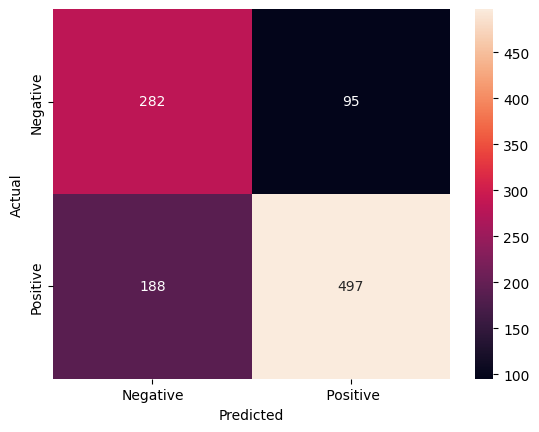

In [43]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results,["Negative", "Positive"],["Negative"," Positive"])
cm = sns.heatmap(df_cm, annot=True, fmt='d')
cm.set_xlabel('Predicted')
cm.set_ylabel('Actual')

fig = cm.get_figure()

In [44]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
iris_model = mr.python.create_model(
    name="wine_model_final", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
iris_model.save(model_dir)


Connected. Call `.close()` to terminate connection gracefully.


Uploading: 100.000%|██████████| 4283177/4283177 elapsed<00:04 remaining<00:003.44it/s]
Uploading: 100.000%|██████████| 19988/19988 elapsed<00:01 remaining<00:001,  3.44it/s]
Uploading: 100.000%|██████████| 629/629 elapsed<00:01 remaining<00:00<00:14,  3.70s/it]
Model export complete: 100%|██████████| 6/6 [00:14<00:00,  2.33s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/194714/models/wine_model_final/2


Model(name: 'wine_model_final', version: 2)